pip install mat73## Notebook to explore statistics of data for Generic Object Decoding dataset.
Which is the best way to pre-process data?


In [1]:
%pip install mat73

Note: you may need to restart the kernel to use updated packages.


In [2]:
import nibabel as nib
import torch
from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from os.path import join as opj
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('omw-1.4')
import tqdm
from torchsummary import summary
from PIL import Image

from sklearn.model_selection import train_test_split
import shutil
from scipy.stats import hypergeom
import seaborn as sns
from termcolor import colored
from sklearn.neighbors import NearestNeighbors
from torchvision.utils import make_grid
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
import nibabel.processing
import pickle
from scipy.io import loadmat
import numpy as np
import pandas as pd
import sklearn.preprocessing
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
import h5py

import mat73
import hdf5storage
import bdpy

from bdpy.bdata import concat_dataset
from bdpy.ml import add_bias
from bdpy.preproc import select_top
from bdpy.stats import corrcoef
from bdpy.util import makedir_ifnot, get_refdata
from bdpy.dataform import append_dataframe
from bdpy.distcomp import DistComp


[nltk_data] Downloading package wordnet to /home/matteo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/matteo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 1. Starting from kamitani?

In [3]:


class data_handler():
    """Generate batches for FMRI prediction
    frames_back - how many video frames to take before FMRI frame
    frames_forward - how many video frames to take after FMRI frame
    
    
    -> NOT USEFUL FOR VOXEL
    
    """

    def __init__(self, h5_file ,test_img_csv = 'KamitaniData/imageID_test.csv',train_img_csv = 'KamitaniData/imageID_training.csv',voxel_spacing =3,log = 0 ):
        
        
        dat=bdpy.BData(h5_file)
        self.dat=dat
        
        self.data = dat.dataset
        #self.sample_meta = mat['dataset'][:,:3]
        #meta = mat['metadata']


        self.meta_keys = list(l for l in dat.metadata.key)
        self.meta_desc = list(l for l in dat.metadata.description )
        
        
#         self.data = mat['dataSet'][:,3:]
#         self.sample_meta = mat['dataSet'][:,:3].astype(np.object_)
#         meta = mat['metaData']
        
        

        # self.voxel_meta = np.nan_to_num(meta[0][0][2][:,3:])
        test_img_df = pd.read_csv(test_img_csv, header=None)
        train_img_df =pd.read_csv(train_img_csv, header=None)
        
        self.test_img_df=test_img_df
        self.train_img_df=train_img_df
        
        self.test_img_id = test_img_df[0].values
        self.train_img_id = train_img_df[0].values
        self.sample_type = {'train':1 , 'test':2 , 'test_imagine' : 3}
        self.voxel_spacing = voxel_spacing

        self.log = log

    def get_meta_field(self,field = 'DataType'):
        index = self.meta_keys.index(field)
        print("index",index)
        if(index <3): # 3 first keys are sample meta
            return self.sample_meta[:,index]
        else:
            return self.voxel_meta[index]


    def print_meta_desc(self):
        print(self.meta_desc)

    def get_labels(self, imag_data = 0,test_run_list = None):
        le = preprocessing.LabelEncoder()

        img_ids = self.dat.select("stimulus_id").squeeze()
        type = self.dat.select('DataType')
        train = (type == self.sample_type['train']).squeeze()
        test = (type == self.sample_type['test']).squeeze()
        imag = (type == self.sample_type['test_imagine']).squeeze()
        
        
        img_ids_train = img_ids[train]
        img_ids_test = img_ids[test]
        img_ids_imag = img_ids[imag]
        
        #print(img_ids_train)

        
        img_train_filenames=[self.train_img_df[self.train_img_df[0]==i][1].values for i in img_ids_train]
        img_test_filenames=[self.test_img_df[self.test_img_df[0]==i][1].values for i in img_ids_test]
        
        self.img_train_filenames=[i.squeeze() for i in img_train_filenames]
        self.img_test_filenames=[i.squeeze() for i in img_test_filenames]
        
        #print(img_train_filenames)

        train_labels  = []
        test_labels  =  []
        imag_labels = []
        for id in img_ids_test:
            idx = (np.abs(id - self.test_img_id)).argmin()
            test_labels.append(idx)

        for id in img_ids_train:
            idx = (np.abs(id - self.train_img_id)).argmin()
            train_labels.append(idx)

        for id in img_ids_imag:
            idx = (np.abs(id - self.test_img_id)).argmin()
            imag_labels.append(idx)

        if (test_run_list is not None):
            run = self.get_meta_field('Run')
            test = (self.get_meta_field('DataType') == 2).astype(bool)
            run = run[test]

            select = np.in1d(run, test_run_list)
            test_labels = test_labels[select]

        #imag_labels = le.fit_transform(img_ids_imag)
        if(imag_data):
            return np.array(train_labels), np.array(test_labels), np.array(imag_labels)
        else:
            return np.array(train_labels),np.array(test_labels)





    def get_data(self,normalize =1 ,roi = 'ROI_VC',imag_data = 0,test_run_list = None):   # normalize 0-no, 1- per run , 2- train/test seperatly
        type = self.dat.select('DataType')
        train = (type == self.sample_type['train']).squeeze()
        test = (type == self.sample_type['test']).squeeze()
        test_imag = (type == self.sample_type['test_imagine']).squeeze()
        test_all  = np.logical_or(test,test_imag)

        roi_select = self.dat.select(roi)
        #data = self.data[:,roi_select]
        
        data=roi_select #not sure!
        
        if(self.log ==1):
            data = np.log(1+np.abs(data))*np.sign(data)


        if(normalize==1):

            run = self.dat.select('Run').astype('int').squeeze()-1
            num_runs = np.max(run)+1
            data_norm = np.zeros(data.shape)

            for r in range(num_runs):
                data_norm[r==run] = sklearn.preprocessing.scale(data[r==run])
            train_data = data_norm[train]
            test_data  = data_norm[test]
            test_all = data_norm[test_all]
            test_imag = data_norm[test_imag]

        else:
            train_data = data[train]
            test_data  =  data[test]
            if(normalize==2):
                train_data = sklearn.preprocessing.scale(train_data)
                test_data = sklearn.preprocessing.scale(test_data)


        if(self.log ==2):
            train_data = np.log(1+np.abs(train_data))*np.sign(train_data)
            test_data = np.log(1+np.abs(test_data))*np.sign(test_data)
            train_data = sklearn.preprocessing.scale(train_data)
            test_data = sklearn.preprocessing.scale(test_data)



        test_labels =  self.get_labels()[1]
        imag_labels = self.get_labels(1)[2]
        num_labels = max(test_labels)+1
        test_data_avg = np.zeros([num_labels,test_data.shape[1]])
        test_imag_avg = np.zeros([num_labels,test_data.shape[1]])

        if(test_run_list is not None):
            run = self.get_meta_field('Run')
            test = (self.get_meta_field('DataType') == 2).astype(bool)
            run = run[test]

            select = np.in1d(run, test_run_list)
            test_data = test_data[select,:]
            test_labels = test_labels[select]

        for i in range(num_labels):
            test_data_avg[i] = np.mean(test_data[test_labels==i],axis=0)
            test_imag_avg[i] = np.mean(test_imag[imag_labels == i], axis=0)
        if(imag_data):
            return train_data, test_data, test_data_avg,test_imag,test_imag_avg

        else:
            return train_data, test_data, test_data_avg

    def get_voxel_loc(self):
        x = self.get_meta_field('voxel_x')
        y = self.get_meta_field('voxel_y')
        z = self.get_meta_field('voxel_z')
        dim = [int(x.max() -x.min()+1),int(y.max() -y.min()+1), int(z.max() -z.min()+1)]
        return [x,y,z] , dim

    
    def get_filenames(self):
        return self.img_train_filenames,self.img_test_filenames

In [4]:
sub="5"
kamitani_data_mat=f"/home/matteo/data/fMRI/GOD/Subject{sub}.h5"

In [5]:
imagenet_dir="/home/matteo/data/fMRI/imagenet/images"


In [6]:
test_img_csv = '/home/matteo/data/fMRI/GOD/imageID_test.csv'
train_img_csv = '/home/matteo/data/fMRI/GOD/imageID_training.csv'
handler = data_handler(h5_file = kamitani_data_mat, test_img_csv =test_img_csv, train_img_csv =train_img_csv)
Y,Y_test,Y_test_avg = handler.get_data(normalize = 1, roi = 'ROI_VC')
labels_train, labels = handler.get_labels()
filenames_train,filenames_test=handler.get_filenames()

filenames_train=[i.item() for i in filenames_train]
filenames_test=[i.item() for i in filenames_test]


In [7]:
filenames_test_avg=[]
for i in range(50):
    filenames_test_avg.append(np.array(filenames_test)[labels==i][0])

#### 4. Experiment with linear model using Kamitani data processing

In [8]:
model=torchvision.models.resnet50(pretrained=True)
modules=list(model.children())[:-1]
model=nn.Sequential(*modules)

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,fmri_data,image_paths,transform=None):
        self.fmri_data=fmri_data
        self.image_paths=image_paths
        self.transform=transform
    def __len__(self):
        return len(self.fmri_data)

    def __getitem__(self, idx):
        
        fmri=self.fmri_data[idx]
        
        
        image = Image.open(self.image_paths[idx]).convert("RGB")
        

        if self.transform:
            image = self.transform(image)

        return fmri,image

In [10]:
img_dir_path="/home/matteo/data/fMRI/imagenet/images/train_dir/training"
image_paths=[os.path.join(img_dir_path,i) for i in filenames_train]

test_image_paths=[os.path.join(imagenet_dir,"test_dir","test",i) for i in filenames_test_avg]

In [11]:
fmri_train,fmri_val,image_train,image_val=train_test_split(Y,image_paths,test_size=0.1,random_state=42)

In [12]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])



transform=torchvision.transforms.Compose([torchvision.transforms.Resize(224),torchvision.transforms.ToTensor(),normalize])

train_dataset=CustomDataset(fmri_train,image_train,transform)
val_dataset=CustomDataset(fmri_val,image_val,transform)

test_dataset=CustomDataset(Y_test_avg,test_image_paths,transform)


train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=False)
val_dataloader=torch.utils.data.DataLoader(val_dataset,batch_size=64,shuffle=False)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False)


In [13]:
## get the lantents
x_train=[]
z_train=[]

x_val=[]
z_val=[]

x_test=[]
z_test=[]


with torch.no_grad():
    for x,y in tqdm.tqdm(train_dataloader):
        z=model(y)
        x_train.append(x)
        z_train.append(z.squeeze())
    for x,y in tqdm.tqdm(val_dataloader):
        z=model(y)
        x_val.append(x)
        z_val.append(z.squeeze())
    for x,y in tqdm.tqdm(test_dataloader):
        z=model(y)
        x_test.append(x)
        z_test.append(z.squeeze())

x_train=torch.cat(x_train,0).numpy()
z_train=torch.cat(z_train,0).numpy()

x_val=torch.cat(x_val,0).numpy()
z_val=torch.cat(z_val,0).numpy()

x_test=torch.cat(x_test,0).numpy()
z_test=torch.cat(z_test,0).numpy()


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


In [14]:
np.sum(x_train[0])

-2038.5018510718173

In [15]:
x_train_big=np.concatenate((x_train,x_val),0)
z_train_big=np.concatenate((z_train,z_val),0)
x_train_big.shape,z_train_big.shape

((1200, 4370), (1200, 2048))

In [16]:
np.array_equal(x_train[0],x_val[0]),np.array_equal(x_train[0],x_test[0])


(False, False)

In [17]:
ridge=Ridge(alpha=1000,max_iter=5000)
ridge.fit(x_train,z_train)

pred_test_latent=ridge.predict(x_test)

epsilon=1e-10

std_norm_test_latent = (pred_test_latent - np.mean(pred_test_latent,axis=0)) / (epsilon+np.std(pred_test_latent,axis=0))
pred_instance = std_norm_test_latent * np.std(z_train,axis=0) + np.mean(z_train,axis=0)

train_predicted=ridge.predict(x_train)
val_predicted=ridge.predict(x_val)

# print("r2",ridge.score(x_train,z_train))
# print("r2",r2_score(z_test,pred_instance))
# print("r2",r2_score(z_test,pred_test_latent))

print("rmse",mean_squared_error(z_train,train_predicted))
print("rmse",mean_squared_error(z_val,val_predicted))
print("rmse",mean_squared_error(z_test,pred_instance))
print("rmse",mean_squared_error(z_test,pred_test_latent))


      


rmse 0.03804447930226393
rmse 0.2121011973390867
rmse 0.27996654996192805
rmse 0.1733106994970634


## Un modello lineare non basta.

In [18]:
def get_activation(activation):
    if activation=="relu":
        return nn.ReLU()
    
    elif activation=="gelu":
        return nn.GELU()
    
    elif activation=="tanh":
        return nn.Tanh()
    
    elif activation=="sigmoid":
        return nn.Sigmoid()

    elif activation=="selu":
        return nn.SELU()

class BrainAttentionMLP(nn.Module):
    def __init__(self,latent_dim,hidden=[128],dropout=0.2,activation="gelu",attn_hidden=128):
        super().__init__()

        self.Q=nn.LazyLinear(attn_hidden)
        self.K=nn.LazyLinear(attn_hidden)
        self.V=nn.LazyLinear(attn_hidden)

        self.attention=nn.MultiheadAttention(attn_hidden,num_heads=8)
        
        self.model=[]
        for h in hidden:
            self.model.append(nn.LazyLinear(h))
            self.model.append(get_activation(activation))

        self.model.append(nn.Dropout(dropout))
        self.model.append(nn.LazyLinear(latent_dim))

        self.model=nn.Sequential(*self.model)
    
    def forward(self,x):
        query=self.Q(x)
        key=self.K(x)
        value=self.V(x)

        attn_output, attn_output_weights=self.attention(query,key,value)

        return self.model(attn_output)


class BrainMLP(nn.Module):
    def __init__(self,latent_dim,hidden=[128],dropout=0.2,activation="gelu"):
        super().__init__()

        
        self.model=[]
        for h in hidden:
            self.model.append(nn.LazyLinear(h))
            self.model.append(get_activation(activation))


        self.model.append(nn.Dropout(dropout))
        
        
        self.model.append(nn.LazyLinear(latent_dim))

        self.model=nn.Sequential(*self.model)
    
    def forward(self,x):
        return self.model(x)




In [19]:
def train_brain_epoch(model,train_dataloader,criterion=None,optim=None,device="cpu"):
    
    model.train()
    
    loss_tmp=[]
    for x,y  in train_dataloader:
        
        optim.zero_grad()
        x,y=x.to(device),y.to(device)

        y_pred=model(x)
        
        #print(f"DEBUG {x.dtype}{y_pred.dtype} {y_pred}")

        if isinstance(criterion,nn.CosineEmbeddingLoss):
            target=torch.ones(y_pred.shape[0]).to(device)

            loss=criterion(y_pred.squeeze(),y.squeeze(),target)

        else:
            
            loss=criterion(y_pred.squeeze(),y.squeeze())
        loss.backward()

        optim.step()

        #print(f"epoch {epoch} loss: {loss}")
        loss_tmp.append(loss.item())
    return np.mean(loss_tmp)


def val_brain_epoch(model,val_dataloader,criterion=None,optim=None,device="cpu"):
    
    model.eval()
    
    loss_tmp=[]
    i=0
    with torch.no_grad():
        for x,y in val_dataloader:


            x,y=x.to(device),y.to(device)

            y_pred=model(x)


            if isinstance(criterion,nn.CosineEmbeddingLoss):
                target=torch.ones(y_pred.shape[0]).to(device)

                loss=criterion(y_pred.squeeze(),y.squeeze(),target)

            else:
                loss=criterion(y_pred.squeeze(),y.squeeze())




            #print(f"epoch {epoch} loss: {loss}")
            loss_tmp.append(loss.item())

                        
    return np.mean(loss_tmp)

In [20]:
brain_model=BrainMLP(latent_dim=2048,hidden=[1024],dropout=0.3,activation="tanh")
summary(brain_model,(x_train.shape[-1],),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       4,475,904
              Tanh-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                 [-1, 2048]       2,099,200
Total params: 6,575,104
Trainable params: 6,575,104
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 25.08
Estimated Total Size (MB): 25.14
----------------------------------------------------------------


/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [21]:
train_brain_dataset=torch.utils.data.TensorDataset(torch.Tensor(x_train),torch.Tensor(z_train))
val_brain_dataset=torch.utils.data.TensorDataset(torch.Tensor(x_val),torch.Tensor(z_val))
test_brain_dataset=torch.utils.data.TensorDataset(torch.Tensor(x_test),torch.Tensor(z_test))


train_brain_dataloader=torch.utils.data.DataLoader(train_brain_dataset,batch_size=64,shuffle=True)
val_brain_dataloader=torch.utils.data.DataLoader(val_brain_dataset,batch_size=64,shuffle=True)
test_brain_dataloader=torch.utils.data.DataLoader(test_brain_dataset,batch_size=64,shuffle=True)


In [22]:
len(train_brain_dataset),len(val_brain_dataset)

(1080, 120)

In [23]:
device="cuda:0"
EPOCHS=200
scheduler_step=60
gamma=0.5

brain_model=brain_model.to(device)


optim=torch.optim.Adam(brain_model.parameters(),lr=3e-3, weight_decay=1e-5)
#optim=torch.optim.SGD(brain_model.parameters(),lr=1e-3,momentum=0.9)
scheduler=torch.optim.lr_scheduler.StepLR(optim,step_size=scheduler_step,gamma=gamma)
criterion=nn.MSELoss()
#criterion=nn.CosineEmbeddingLoss()




In [24]:
loss_history=[]
val_loss_history=[]

val_freq=1

train=True
if train:
    pbar=tqdm.tqdm(range(EPOCHS))
    for epoch in pbar:

        loss=train_brain_epoch(brain_model,train_dataloader=train_brain_dataloader,criterion=criterion,optim=optim,device=device)

        scheduler.step()

        loss_history.append(loss)
        #print(f"[TRAIN] epoch {epoch} loss: {loss}")


        if epoch%val_freq==0:
            val_loss=val_brain_epoch(brain_model,val_dataloader=val_brain_dataloader,criterion=criterion,optim=optim,device=device)
            val_loss_history.append(val_loss)

            #print(f"[VAL] epoch {epoch} val_loss: {val_loss}")
        if epoch>val_freq:
            pbar.set_description(f"[INFO] epoch: {epoch} loss: {loss_history[-1]} val_loss: {val_loss_history[-1]}")
        else:
            pbar.set_description(f"[INFO] epoch: {epoch} loss: {loss_history[-1]}")
            
else:
    brain_model.load_state_dict(torch.load(f"kamitani_models/brain_model_weights_sub{sub}.pt"))
    brain_model=brain_model.to(device)
    ridge = pickle.load(open(f"kamitani_models/ridge_sub{sub}.sav", 'rb'))

[INFO] epoch: 199 loss: 0.04391059673884336 val_loss: 0.2275770604610443: 100%|█


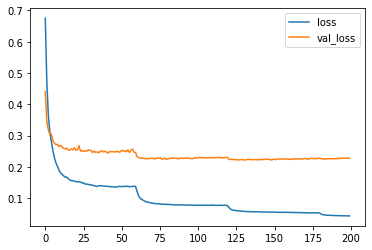

In [25]:
if train:
    plt.plot(loss_history,label="loss")
    plt.plot(val_loss_history,label="val_loss")
    plt.legend()

In [26]:
with torch.no_grad():
    train_predict=brain_model(torch.Tensor(x_train).to(device)).cpu().numpy()
    val_predict=brain_model(torch.Tensor(x_val).to(device)).cpu().numpy()
    test_predict=brain_model(torch.Tensor(x_test).to(device)).cpu().numpy()
    
    std_norm_test_latent = (test_predict - np.mean(test_predict,axis=0)) / np.std(test_predict,axis=0)
    test_predicted_adjusted = std_norm_test_latent * np.std(z_train,axis=0) + np.mean(z_train,axis=0)


In [27]:
print("rmse",mean_squared_error(z_train,train_predict))
print("rmse",mean_squared_error(z_val,val_predict))
print("rmse",mean_squared_error(z_test,test_predicted_adjusted))
print("rmse",mean_squared_error(z_test,test_predict))


rmse 0.019812558
rmse 0.22735947
rmse 0.2776801
rmse 0.17872867


In [28]:
os.makedirs("kamitani_models",exist_ok=True)



In [29]:
if train:
    pickle.dump(ridge, open(f"kamitani_models/ridge_sub{sub}.sav", 'wb'))
    torch.save(brain_model,f"kamitani_models/brain_model_sub{sub}.pt")
    torch.save(brain_model.state_dict(),f"kamitani_models/brain_model_weights_sub{sub}.pt")


### Try combination with kNN

Valutation in different modalities:

brain model + clf

brain model + kNN

ridge + clf

ridge + kNN


In [30]:
with open('classes.txt', 'rb') as handle:
    data_dict = handle.read()
idx2name= pickle.loads(data_dict)

In [31]:
features_path="/home/matteo/fMRI_classification/captioning/features/feature_imagenet_500_resnet50.pt"
labels_path="/home/matteo/fMRI_classification/captioning/features/labels_imagenet_500_resnet50.pt"

In [32]:
features=torch.load(features_path)
labels=torch.load(labels_path)


In [33]:
nbrs= NearestNeighbors(n_neighbors=5).fit(features.numpy())
knn_clf=KNeighborsClassifier(n_neighbors=20,n_jobs=16)
knn_clf.fit(features.numpy(),labels.numpy())

KNeighborsClassifier(n_jobs=16, n_neighbors=20)

#### Validation images

In [34]:
x,y=next(iter(val_dataloader))

z_val_brain=[]
z_val_ridge=[]
z_val_model=[]
images_val=[]

with torch.no_grad():
    for x,y in tqdm.tqdm(val_dataloader):
        
        z_b=brain_model(x.float().to(device)).cpu()
        z_m=model(y).cpu().squeeze()
        z_r=torch.Tensor(ridge.predict(x.numpy()))
        
        
        z_val_brain.append(z_b)
        z_val_model.append(z_m)
        z_val_ridge.append(z_r)
        
        images_val.append(y)
        

        
        
        
        
    
z_val_brain=torch.cat(z_val_brain,0)
z_val_model=torch.cat(z_val_model,0)
z_val_ridge=torch.cat(z_val_ridge,0)

images_val=torch.cat(images_val,0)
    
                    

100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/it]


In [35]:
z_val_brain.shape,z_val_model.shape,z_val_ridge.shape

(torch.Size([120, 2048]), torch.Size([120, 2048]), torch.Size([120, 2048]))

In [36]:
clf=torchvision.models.resnet50(pretrained=True)
modules=list(clf.children())[-1:]
clf=nn.Sequential(*modules)

In [37]:

out_model=clf(z_val_model) 

out_brain=clf(z_val_brain)
out_ridge=clf(z_val_ridge)



In [38]:
unnorm = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1.,1.,1.] )])


In [39]:
i= 0

# knn_brain=knn_clf.predict(z_val_brain[i].numpy().reshape(1,-1))
# knn_model=knn_clf.predict(z_val_model[i].numpy().reshape(1,-1))
# knn_ridge=knn_clf.predict(z_val_ridge[i].numpy().reshape(1,-1))

# nn_brain=nbrs.kneighbors(z_val_brain[i].numpy().reshape(1,-1))
# nn_model=nbrs.kneighbors(z_val_model[i].numpy().reshape(1,-1))
# nn_ridge=nbrs.kneighbors(z_val_ridge[i].numpy().reshape(1,-1))


# plt.imshow(unnorm(images_val[i]).permute(1,2,0))
# plt.title(f"model: {idx2name[out_model[i].argmax().item()]}")

# print(f"clf brain: {idx2name[out_brain[i].argmax().item()]}")
# print(f"clf ridge: {idx2name[out_ridge[i].argmax().item()]}")
# print()

# nn_model_guess=[idx2name[i.item()] for i in labels[nn_model[1][0]]]
# nn_brain_guess=[idx2name[i.item()] for i in labels[nn_brain[1][0]]]
# nn_ridge_guess=[idx2name[i.item()] for i in labels[nn_ridge[1][0]]]

# print(f"NN [MODEL] closest: {nn_model_guess[0]}")
# print(f"NN [BRAIN] closest: {nn_brain_guess[0]}")
# print(f"NN [RIDGE] closest: {nn_ridge_guess[0]}")
# print()

# # print(f"kNN [MODEL] closest: {idx2name[knn_model[0]]}")
# # print(f"kNN [BRAIN] closest: {idx2name[knn_brain[0]]}")
# # print(f"kNN [RIDGE] closest: {idx2name[knn_ridge[0]]}")
# # print()


# print(f"NN [MODEL] other guess: {' '.join(nn_model_guess)}")
# print(f"NN [BRAIN] other guess: {' '.join(nn_brain_guess)}")
# print(f"NN [RIDGE] other guess: {' '.join(nn_ridge_guess)}")



### LAVORARE QUA

# brain_guess=[idx2name[i.item()] for i in labels[out[1][0]]]
# print(out,out_true)
# print(f"brain guess: {' '.join(brain_guess)}")

In [40]:
# final_out_val=[]
# for i in tqdm.tqdm(range(len(images_val))):
#     nn_ridge=nbrs.kneighbors(z_val_ridge[i].numpy().reshape(1,-1))
#     nn_brain=nbrs.kneighbors(z_val_brain[i].numpy().reshape(1,-1))

#     output=list(labels[nn_ridge[1][0]].numpy())+[out_ridge[i].argmax().item()]+list(labels[nn_brain[1][0]].numpy())+[out_brain[i].argmax().item()]
#     final_out_val.append(output)

In [41]:
os.makedirs("output",exist_ok=True)

In [42]:
# np.savez(f"output/val_images_ridge_brain_sub{sub}.npz",images_val,np.array(final_out_val))

#### test images

In [43]:

z_test_brain=[]
z_test_ridge=[]
z_test_model=[]
images_test=[]

with torch.no_grad():
    for x,y in tqdm.tqdm(test_dataloader):
        
        z_b=brain_model(x.float().to(device)).cpu()
        z_m=model(y).cpu().squeeze()
        z_r=torch.Tensor(ridge.predict(x.numpy()))
        
        
        z_test_brain.append(z_b)
        z_test_model.append(z_m)
        z_test_ridge.append(z_r)
        
        images_test.append(y)
        

        
        
        
        
    
z_test_brain=torch.cat(z_test_brain,0)
z_test_model=torch.cat(z_test_model,0)
z_test_ridge=torch.cat(z_test_ridge,0)

images_test=torch.cat(images_test,0)
    
                    

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


In [44]:
z_test_brain_std_norm=(z_test_brain-z_test_brain.mean(dim=0))/z_test_brain.std(dim=0)
z_test_brain_adj=z_test_brain_std_norm*np.std(z_train,axis=0)+np.mean(z_train,axis=0)

z_test_ridge_std_norm=(z_test_ridge-z_test_ridge.mean(dim=0))/z_test_ridge.std(dim=0)
z_test_ridge_adj=z_test_ridge_std_norm*np.std(z_train,axis=0)+np.mean(z_train,axis=0)


    # std_norm_test_latent = (test_predict - np.mean(test_predict,axis=0)) / np.std(test_predict,axis=0)
    # test_predicted_adjusted = std_norm_test_latent * np.std(z_train,axis=0) + np.mean(z_train,axis=0)

In [45]:
out_test_brain=clf(z_test_brain_adj)
out_test_model=clf(z_test_model)
out_test_ridge=clf(z_test_ridge_adj)


clf brain: parachute, chute
clf ridge: water buffalo, water ox, Asiatic buffalo, Bubalus bubalis

NN [MODEL] closest: canoe
NN [BRAIN] closest: volleyball
NN [RIDGE] closest: volleyball

NN [MODEL] other guess: canoe canoe canoe canoe canoe
NN [BRAIN] other guess: volleyball unicycle, monocycle howler monkey, howler swimming trunks, bathing trunks rugby ball
NN [RIDGE] other guess: volleyball sturgeon baseball unicycle, monocycle amphibian, amphibious vehicle


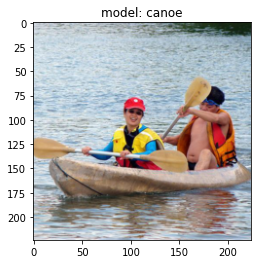

In [46]:
i= np.random.randint(0,50)


# knn_brain=knn_clf.predict(z_test_brain_adj[i].numpy().reshape(1,-1))
# knn_model=knn_clf.predict(z_test_model[i].numpy().reshape(1,-1))
# knn_ridge=knn_clf.predict(z_test_ridge_adj[i].numpy().reshape(1,-1))

nn_brain=nbrs.kneighbors(z_test_brain_adj[i].numpy().reshape(1,-1))
nn_model=nbrs.kneighbors(z_test_model[i].numpy().reshape(1,-1))
nn_ridge=nbrs.kneighbors(z_test_ridge_adj[i].numpy().reshape(1,-1))


plt.imshow(unnorm(images_test[i]).permute(1,2,0))
plt.title(f"model: {idx2name[out_test_model[i].argmax().item()]}")

print(f"clf brain: {idx2name[out_test_brain[i].argmax().item()]}")
print(f"clf ridge: {idx2name[out_test_ridge[i].argmax().item()]}")
print()

nn_model_guess=[idx2name[i.item()] for i in labels[nn_model[1][0]]]
nn_brain_guess=[idx2name[i.item()] for i in labels[nn_brain[1][0]]]
nn_ridge_guess=[idx2name[i.item()] for i in labels[nn_ridge[1][0]]]

print(f"NN [MODEL] closest: {nn_model_guess[0]}")
print(f"NN [BRAIN] closest: {nn_brain_guess[0]}")
print(f"NN [RIDGE] closest: {nn_ridge_guess[0]}")
print()

# print(f"kNN [MODEL] closest: {idx2name[knn_model[0]]}")
# print(f"kNN [BRAIN] closest: {idx2name[knn_brain[0]]}")
# print(f"kNN [RIDGE] closest: {idx2name[knn_ridge[0]]}")
# print()

print(f"NN [MODEL] other guess: {' '.join(nn_model_guess)}")
print(f"NN [BRAIN] other guess: {' '.join(nn_brain_guess)}")
print(f"NN [RIDGE] other guess: {' '.join(nn_ridge_guess)}")


### LAVORARE QUA

# brain_guess=[idx2name[i.item()] for i in labels[out[1][0]]]
# print(out,out_true)
# print(f"brain guess: {' '.join(brain_guess)}")

In [47]:
len(out_brain)

120

In [48]:
final_out_test=[]
for i in tqdm.tqdm(range(len(images_test))):
    nn_ridge=nbrs.kneighbors(z_test_ridge_adj[i].numpy().reshape(1,-1))
    nn_brain=nbrs.kneighbors(z_test_brain_adj[i].numpy().reshape(1,-1))

    output=list(labels[nn_ridge[1][0]].numpy())+[out_test_ridge[i].argmax().item()]+list(labels[nn_brain[1][0]].numpy())+[out_test_brain[i].argmax().item()]
    final_out_test.append(output)

100%|███████████████████████████████████████████| 50/50 [05:45<00:00,  6.92s/it]


In [49]:
np.savez(f"output/test_images_ridge_brain_sub{sub}.npz",images_test,np.array(final_out_test))

### Overfit a batch

In [50]:
x,y=next(iter(train_dataloader))

z_train_brain=[]
z_train_ridge=[]
z_train_model=[]
images_train=[]

with torch.no_grad():

    z_b=brain_model(x.float().to(device)).cpu()
    z_m=model(y).cpu().squeeze()
    z_r=torch.Tensor(ridge.predict(x.numpy()))
        
        
    z_train_brain.append(z_b)
    z_train_model.append(z_m)
    z_train_ridge.append(z_r)

    images_train.append(y)
        

        
        
        
z_train_brain=torch.cat(z_train_brain,0)
z_train_model=torch.cat(z_train_model,0)
z_train_ridge=torch.cat(z_train_ridge,0)

images_train=torch.cat(images_train,0)
                    

In [51]:
out_train_brain=clf(z_train_brain)
out_train_model=clf(z_train_model)
out_train_ridge=clf(z_train_ridge)


clf brain: paper towel
clf ridge: paper towel

NN [MODEL] closest: cowboy hat, ten-gallon hat
NN [BRAIN] closest: piggy bank, penny bank
NN [RIDGE] closest: letter opener, paper knife, paperknife

NN [MODEL] other guess: cowboy hat, ten-gallon hat paper towel cowboy hat, ten-gallon hat abacus eggnog
NN [BRAIN] other guess: piggy bank, penny bank corkscrew, bottle screw wooden spoon candle, taper, wax light eggnog
NN [RIDGE] other guess: letter opener, paper knife, paperknife piggy bank, penny bank candle, taper, wax light quill, quill pen Brabancon griffon


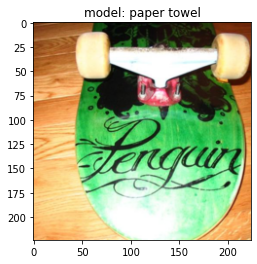

In [52]:
i= np.random.randint(0,16)

nn_brain=nbrs.kneighbors(z_train_brain[i].numpy().reshape(1,-1))
nn_model=nbrs.kneighbors(z_train_model[i].numpy().reshape(1,-1))
nn_ridge=nbrs.kneighbors(z_train_ridge[i].numpy().reshape(1,-1))


plt.imshow(unnorm(images_train[i]).permute(1,2,0))
plt.title(f"model: {idx2name[out_train_model[i].argmax().item()]}")

print(f"clf brain: {idx2name[out_train_brain[i].argmax().item()]}")
print(f"clf ridge: {idx2name[out_train_ridge[i].argmax().item()]}")
print()

nn_model_guess=[idx2name[i.item()] for i in labels[nn_model[1][0]]]
nn_brain_guess=[idx2name[i.item()] for i in labels[nn_brain[1][0]]]
nn_ridge_guess=[idx2name[i.item()] for i in labels[nn_ridge[1][0]]]

print(f"NN [MODEL] closest: {nn_model_guess[0]}")
print(f"NN [BRAIN] closest: {nn_brain_guess[0]}")
print(f"NN [RIDGE] closest: {nn_ridge_guess[0]}")
print()

print(f"NN [MODEL] other guess: {' '.join(nn_model_guess)}")
print(f"NN [BRAIN] other guess: {' '.join(nn_brain_guess)}")
print(f"NN [RIDGE] other guess: {' '.join(nn_ridge_guess)}")


### LAVORARE QUA

# brain_guess=[idx2name[i.item()] for i in labels[out[1][0]]]
# print(out,out_true)
# print(f"brain guess: {' '.join(brain_guess)}")

In [53]:
number=16
final_out_train=[]
for i in tqdm.tqdm(range(number)):
    nn_ridge=nbrs.kneighbors(z_train_ridge[i].numpy().reshape(1,-1))
    nn_brain=nn_ridge ## metteo due volte ridge è voluto

    output=list(labels[nn_ridge[1][0]].numpy())+[out_train_ridge[i].argmax().item()]+list(labels[nn_brain[1][0]].numpy())+[out_train_ridge[i].argmax().item()]
    final_out_train.append(output)

np.savez(f"output/train_images_ridge_brain_sub{sub}.npz",images_train[:number],np.array(final_out_train))

100%|███████████████████████████████████████████| 16/16 [00:55<00:00,  3.47s/it]
